## Metro-Milwaukee School Landscape Performance: 

Milwaukee and it's surrounding communities are regularly ranked as one of the most racially and economically segregated metro areas in the United States. In this project I aim to see if there is any structure to the school landscape in and around Milwaukee based on State Report Card school performance indicators and student body demographic information. 

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
    $('div.input').hide();
    } else {
    $('div.input').show();
    }
    code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    The raw code for this IPython notebook is by default hidden for easier reading.
    To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
df = pd.read_excel(r'/Users/steveangeli/Desktop/Thinkful Data Science Projects/Unsupervised Learning Capstone/2018-19_school_reportcard_data.xlsx', sheet_name='Data')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df.head()

,School Year,District Code,School Code,District Name,School Name,Overall Accountability Score,Overall Accountability Rating,Lowest Grade in the School,Highest Grade in the School,School Type,School Enrollment,District Enrollment,Percent American Indian or Alaskan Native,Percent Asian,Percent Black or African American,Percent Hispanic/Latino,Percent Native Hawaiian or Other Pacific Islander,Percent White,Percent Two or More Races,Percent Students with Disabilities,Percent Economically Disadvantaged,Percent Limited English Proficient,Percent School Choice Program,Percent Open Enrollment,School Student Achievement Score,School ELA Achievement Score,School Mathematics Achievement Score,School Student Growth Score,School ELA Growth Score,School Mathematics Growth Score,School Closing Gaps Score,School ELA Gap Score,School Mathematics Gap Score,School 4 Year Graduation Gap Score,School 6 Year Graduation Gap Score,School Graduation Gap Score,School On-Track and Postsecondary Readiness Score,School Graduation Rate Score,School Attendance Rate Score,School Third-Grade ELA Achievement Score,School Eighth-Grade Mathematics Achievement Score,School Student Achievement Max Score,School ELA Achievement Max Score,School Mathematics Achievement Max Score,School Student Growth Max Score,School ELA Growth Max Score,School Mathematics Growth Max Score,School Closing Gaps Max Score,School ELA Achievement Gap Max Score,School Mathematics Achievement Gap Max Score,School Graduation Gap Max Score,School On-Track and Postsecondary Readiness Max Score,School Graduation Rate Max Score,School Attendance Rate Max Score,School Third-Grade ELA Achievement Max Score,School Eighth-Grade Mathematics Achievement Max Score,State Student Achievement Score,State ELA Achievement Score,State Mathematics Achievement Score,State Student Growth Score,State ELA Growth Score,State Mathematics Growth Score,State Closing Gaps Score,State ELA Achievement Gaps Score,State Mathematics Achievement Gaps Score,State Graduation Gaps Score,State On-Track and Postsecondary Readiness Score,State Graduation Rate Score,State Attendance Rate Score,State Third-Grade ELA Achievement Score,State Eighth-Grade Mathematics Achievement Score,State Student Achievement Max Score,State ELA Achievement Max Score,State Mathematics Achievement Max Score,State Student Growth Max Score,State ELA Growth Max Score,State Mathematics Growth Max Score,State Closing Gaps Max Score,State ELA Achievement Gaps Max Score,State Mathematics Achievement Gaps Max Score,State 4 Year Graduation Gaps Max Score,State 6 Year Graduation Gaps Max Score,State Graduation Gaps Max Score,State On-Track and Postsecondary Readiness Max Score,State Graduation Rate Max Score,State Attendance Rate Max Score,State Third-Grade ELA Achievement Max Score,State Eighth-Grade Mathematics Achievement Max Score,Student Engagement Indicators Deduction,Absenteeism Rate Deduction,Dropout Rate Deduction,Test Partcipation ELA 2019 All Students,Test Partcipation ELA MULTI-YEAR All Students,Test Partcipation Mathematics 2019 All Students,Test Partcipation Mathematics MULTI-YEAR All Students,Subgroup with lowest test participation rate 2019,Test Partcipation ELA 2019 lowest rate subgroup,Test Partcipation ELA MULTI-YEAR lowest rate subgroup,Test Partcipation Mathematics 2019 lowest rate subgroup,Test Partcipation Mathematics MULTI-YEAR lowest rate subgroup,Score weighting Achievement Priority Area,Score weighting Growth Priority Area,Score weighting Closing Gaps Priority Area,Score weighting Ontrack Priority Area,School Percent Proficient ELA 2015,State Percent Proficient ELA 2015,School Percent Proficient Mathematics 2015,State Percent Proficient Mathematics 2015,School Percent Proficient ELA 2016,State Percent Proficient ELA 2016,School Percent Proficient Mathematics 2016,State Percent Proficient Mathematics 2016,School Percent Proficient ELA 2017,State Percent Proficient ELA 2017,School Percent Proficient Mathematics 2017,State Percent Profic

![cesa.png](img/cesa.png)

Wisconsin is broken up into educational regions called "CESAs". For this project we're going to look at all schools within the CESA 1 geographical zone. To ensure that I capture both public and private schools, which are not assigned to any particular CESA, I grab the cities in the region and use the City feature to capture all schools. This area provides a good mix of rural, suburban, and urban schools.

In [3]:
cesa1 = df[df["CESA"] == 1]
cities = cesa1['City'].unique()
cities

array(['Racine', 'Milwaukee', 'Hartland', 'Oak Creek', 'Waukesha',
       'Brown Deer', 'Cedarburg', 'Sturtevant', 'West Milwaukee',
       'Cudahy', 'South Milwaukee', 'Whitefish Bay', 'Elm Grove',
       'Brookfield', 'Mount Pleasant', 'Franklin', 'Kenosha', 'Colgate',
       'Germantown', 'Glendale', 'West Allis', 'Menomonee Falls',
       'Grafton', 'Greendale', 'Greenfield', 'Hales Corners', 'Sussex',
       'Lannon', 'New Berlin', 'Pleasant Prairie', 'Delafield', 'Dousman',
       'Wales', 'Genesee Depot', 'Wauwatosa', 'River Hills', 'Fox Point',
       'Mequon', 'Merton', 'Big Bend', 'Mukwonago', 'Eagle',
       'North Prairie', 'Muskego', 'Wind Lake', 'North Lake', 'Fredonia',
       'Oconomowoc', 'Ixonia', 'Pewaukee', 'Port Washington', 'Saukville',
       'Butler', 'Saint Francis', 'Somers', 'Shorewood', 'Caledonia'],
      dtype=object)

In [4]:
df = df[df["City"].isin(cities)]
df.head()

,School Year,District Code,School Code,District Name,School Name,Overall Accountability Score,Overall Accountability Rating,Lowest Grade in the School,Highest Grade in the School,School Type,School Enrollment,District Enrollment,Percent American Indian or Alaskan Native,Percent Asian,Percent Black or African American,Percent Hispanic/Latino,Percent Native Hawaiian or Other Pacific Islander,Percent White,Percent Two or More Races,Percent Students with Disabilities,Percent Economically Disadvantaged,Percent Limited English Proficient,Percent School Choice Program,Percent Open Enrollment,School Student Achievement Score,School ELA Achievement Score,School Mathematics Achievement Score,School Student Growth Score,School ELA Growth Score,School Mathematics Growth Score,School Closing Gaps Score,School ELA Gap Score,School Mathematics Gap Score,School 4 Year Graduation Gap Score,School 6 Year Graduation Gap Score,School Graduation Gap Score,School On-Track and Postsecondary Readiness Score,School Graduation Rate Score,School Attendance Rate Score,School Third-Grade ELA Achievement Score,School Eighth-Grade Mathematics Achievement Score,School Student Achievement Max Score,School ELA Achievement Max Score,School Mathematics Achievement Max Score,School Student Growth Max Score,School ELA Growth Max Score,School Mathematics Growth Max Score,School Closing Gaps Max Score,School ELA Achievement Gap Max Score,School Mathematics Achievement Gap Max Score,School Graduation Gap Max Score,School On-Track and Postsecondary Readiness Max Score,School Graduation Rate Max Score,School Attendance Rate Max Score,School Third-Grade ELA Achievement Max Score,School Eighth-Grade Mathematics Achievement Max Score,State Student Achievement Score,State ELA Achievement Score,State Mathematics Achievement Score,State Student Growth Score,State ELA Growth Score,State Mathematics Growth Score,State Closing Gaps Score,State ELA Achievement Gaps Score,State Mathematics Achievement Gaps Score,State Graduation Gaps Score,State On-Track and Postsecondary Readiness Score,State Graduation Rate Score,State Attendance Rate Score,State Third-Grade ELA Achievement Score,State Eighth-Grade Mathematics Achievement Score,State Student Achievement Max Score,State ELA Achievement Max Score,State Mathematics Achievement Max Score,State Student Growth Max Score,State ELA Growth Max Score,State Mathematics Growth Max Score,State Closing Gaps Max Score,State ELA Achievement Gaps Max Score,State Mathematics Achievement Gaps Max Score,State 4 Year Graduation Gaps Max Score,State 6 Year Graduation Gaps Max Score,State Graduation Gaps Max Score,State On-Track and Postsecondary Readiness Max Score,State Graduation Rate Max Score,State Attendance Rate Max Score,State Third-Grade ELA Achievement Max Score,State Eighth-Grade Mathematics Achievement Max Score,Student Engagement Indicators Deduction,Absenteeism Rate Deduction,Dropout Rate Deduction,Test Partcipation ELA 2019 All Students,Test Partcipation ELA MULTI-YEAR All Students,Test Partcipation Mathematics 2019 All Students,Test Partcipation Mathematics MULTI-YEAR All Students,Subgroup with lowest test participation rate 2019,Test Partcipation ELA 2019 lowest rate subgroup,Test Partcipation ELA MULTI-YEAR lowest rate subgroup,Test Partcipation Mathematics 2019 lowest rate subgroup,Test Partcipation Mathematics MULTI-YEAR lowest rate subgroup,Score weighting Achievement Priority Area,Score weighting Growth Priority Area,Score weighting Closing Gaps Priority Area,Score weighting Ontrack Priority Area,School Percent Proficient ELA 2015,State Percent Proficient ELA 2015,School Percent Proficient Mathematics 2015,State Percent Proficient Mathematics 2015,School Percent Proficient ELA 2016,State Percent Proficient ELA 2016,School Percent Proficient Mathematics 2016,State Percent Proficient Mathematics 2016,School Percent Proficient ELA 2017,State Percent Proficient ELA 2017,School Percent Proficient Mathematics 2017,State Percent Profic

In [5]:
print(df["Grade Band for Comparison Schools"].isnull().sum())

df["Grade Band for Comparison Schools"] = df["Grade Band for Comparison Schools"].astype(str)
print(df["Grade Band for Comparison Schools"].value_counts())
replacements = {'Grade Band for Comparison Schools': {'2019-06-08 00:00:00': '6-8', '2019-09-12 00:00:00': '9-12', '2019-06-12 00:00:00': '6-12'}}
df.replace(replacements, inplace=True)
print(df["Grade Band for Comparison Schools"].value_counts())

0
K-8                    270
K-5                    226
2019-09-12 00:00:00    116
2019-06-08 00:00:00     58
K-12                    47
2019-06-12 00:00:00     19
Name: Grade Band for Comparison Schools, dtype: int64
K-8     270
K-5     226
9-12    116
6-8      58
K-12     47
6-12     19
Name: Grade Band for Comparison Schools, dtype: int64


In [6]:
df["Agency type"].value_counts()

Public school                   468
Private school                  244
Non District Charter Schools     24
Name: Agency type, dtype: int64

In [7]:
# For this project we're going to take a look at the two most common types of schools. K-8s, K-5s, and 9-12s

In [8]:
keep = ["K-5", "K-8", "9-12"]
df = df[df["Grade Band for Comparison Schools"].isin(keep)]
df["Grade Band for Comparison Schools"].value_counts()

K-8     270
K-5     226
9-12    116
Name: Grade Band for Comparison Schools, dtype: int64

## Null Treatment (All Schools)

In [9]:
df.isnull().any()

School Year                                                      False
District Code                                                    False
School Code                                                      False
District Name                                                    False
School Name                                                      False
Overall Accountability Score                                      True
Overall Accountability Rating                                    False
Lowest Grade in the School                                       False
Highest Grade in the School                                      False
School Type                                                      False
School Enrollment                                                False
District Enrollment                                               True
Percent American Indian or Alaskan Native                        False
Percent Asian                                                    False
Percen

In [10]:
# Remove any school that doesn't have an accountability score, rating, or enrollment.

df = df.dropna(axis=0, how='any', subset=["Overall Accountability Score", "Overall Accountability Rating", "School Enrollment"])
df["Agency type"].value_counts()

# Doing this removes nearly HALF of the private schools in the area. 

Public school                   382
Private school                  150
Non District Charter Schools     22
Name: Agency type, dtype: int64

In [11]:
# Drop some irrelevant information
df = df.drop(['District Enrollment', 'No Score Note', 'Open enrollment note', 'Single-school district note', 
         'Accountability Resource Link', 'Percent Choice Note', 'Change Outlier Note', 'Notes.1', 'Notes'], axis=1)

In [12]:
# Fill in empty values for school choice participation.
values = {"Percent School Choice Program":0.0}
df.fillna(value=values, inplace=True)

In [13]:
df.isnull().any()

School Year                                                      False
District Code                                                    False
School Code                                                      False
District Name                                                    False
School Name                                                      False
Overall Accountability Score                                     False
Overall Accountability Rating                                    False
Lowest Grade in the School                                       False
Highest Grade in the School                                      False
School Type                                                      False
School Enrollment                                                False
Percent American Indian or Alaskan Native                        False
Percent Asian                                                    False
Percent Black or African American                                False
Percen

## Duplicate Treatment

In [14]:
duplicates = df[df.duplicated(subset = 'School Code', keep=False)]
duplicates = duplicates.sort_values(by=['School Code'])
duplicates.head()

,School Year,District Code,School Code,District Name,School Name,Overall Accountability Score,Overall Accountability Rating,Lowest Grade in the School,Highest Grade in the School,School Type,School Enrollment,Percent American Indian or Alaskan Native,Percent Asian,Percent Black or African American,Percent Hispanic/Latino,Percent Native Hawaiian or Other Pacific Islander,Percent White,Percent Two or More Races,Percent Students with Disabilities,Percent Economically Disadvantaged,Percent Limited English Proficient,Percent School Choice Program,Percent Open Enrollment,School Student Achievement Score,School ELA Achievement Score,School Mathematics Achievement Score,School Student Growth Score,School ELA Growth Score,School Mathematics Growth Score,School Closing Gaps Score,School ELA Gap Score,School Mathematics Gap Score,School 4 Year Graduation Gap Score,School 6 Year Graduation Gap Score,School Graduation Gap Score,School On-Track and Postsecondary Readiness Score,School Graduation Rate Score,School Attendance Rate Score,School Third-Grade ELA Achievement Score,School Eighth-Grade Mathematics Achievement Score,School Student Achievement Max Score,School ELA Achievement Max Score,School Mathematics Achievement Max Score,School Student Growth Max Score,School ELA Growth Max Score,School Mathematics Growth Max Score,School Closing Gaps Max Score,School ELA Achievement Gap Max Score,School Mathematics Achievement Gap Max Score,School Graduation Gap Max Score,School On-Track and Postsecondary Readiness Max Score,School Graduation Rate Max Score,School Attendance Rate Max Score,School Third-Grade ELA Achievement Max Score,School Eighth-Grade Mathematics Achievement Max Score,State Student Achievement Score,State ELA Achievement Score,State Mathematics Achievement Score,State Student Growth Score,State ELA Growth Score,State Mathematics Growth Score,State Closing Gaps Score,State ELA Achievement Gaps Score,State Mathematics Achievement Gaps Score,State Graduation Gaps Score,State On-Track and Postsecondary Readiness Score,State Graduation Rate Score,State Attendance Rate Score,State Third-Grade ELA Achievement Score,State Eighth-Grade Mathematics Achievement Score,State Student Achievement Max Score,State ELA Achievement Max Score,State Mathematics Achievement Max Score,State Student Growth Max Score,State ELA Growth Max Score,State Mathematics Growth Max Score,State Closing Gaps Max Score,State ELA Achievement Gaps Max Score,State Mathematics Achievement Gaps Max Score,State 4 Year Graduation Gaps Max Score,State 6 Year Graduation Gaps Max Score,State Graduation Gaps Max Score,State On-Track and Postsecondary Readiness Max Score,State Graduation Rate Max Score,State Attendance Rate Max Score,State Third-Grade ELA Achievement Max Score,State Eighth-Grade Mathematics Achievement Max Score,Student Engagement Indicators Deduction,Absenteeism Rate Deduction,Dropout Rate Deduction,Test Partcipation ELA 2019 All Students,Test Partcipation ELA MULTI-YEAR All Students,Test Partcipation Mathematics 2019 All Students,Test Partcipation Mathematics MULTI-YEAR All Students,Subgroup with lowest test participation rate 2019,Test Partcipation ELA 2019 lowest rate subgroup,Test Partcipation ELA MULTI-YEAR lowest rate subgroup,Test Partcipation Mathematics 2019 lowest rate subgroup,Test Partcipation Mathematics MULTI-YEAR lowest rate subgroup,Score weighting Achievement Priority Area,Score weighting Growth Priority Area,Score weighting Closing Gaps Priority Area,Score weighting Ontrack Priority Area,School Percent Proficient ELA 2015,State Percent Proficient ELA 2015,School Percent Proficient Mathematics 2015,State Percent Proficient Mathematics 2015,School Percent Proficient ELA 2016,State Percent Proficient ELA 2016,School Percent Proficient Mathematics 2016,State Percent Proficient Mathematics 2016,School Percent Proficient ELA 2017,State Percent Proficient ELA 2017,School Percent Proficient Mathematics 2017,State Percent Proficient Mathematics 201

In [15]:
df["District Code"] = df["District Code"].astype(str)
df["School Code"] = df["School Code"].astype(str)

In [16]:
df["Unique School Code"] = df["District Code"] + "-" + df["School Code"]

In [17]:
df = df.drop(["District Code", "School Code"], axis=1)

In [18]:
duplicates = df[df.duplicated(subset = 'Unique School Code', keep=False)]
duplicates.head()

# Ok, so a very interesting thing is going on here. Private schools are reporting two sets of data, the first set
# is for kids who are participating in the Choice program (getting a voucher to attend the school) and the second
# set of data is for all kids attending the school. I want to keep the entry that reflects all kids in the school.

drop_duplicates = df[df.duplicated(subset = 'Unique School Code', keep='last')]
df = df.drop(drop_duplicates.index, axis=0)

duplicates = df[df.duplicated(subset = 'Unique School Code', keep=False)]
len(duplicates)

0

In [19]:
df_na = (["School Student Achievement Score", "School Student Growth Score"])

df = df.dropna(axis=0, how='any', subset=df_na)
df["Locale description"].fillna(value="Other", inplace=True)

## Split the Data

In [20]:
k5_df = df[df["Grade Band for Comparison Schools"] == "K-5"]
k8_df = df[df["Grade Band for Comparison Schools"] == "K-8"]
hs_df = df[df["Grade Band for Comparison Schools"] == "9-12"]

In [21]:
print("--------All Schools--------\n")
print(df['Agency type'].value_counts())
print("\n--------K-5 Schools--------\n")
print(k5_df['Agency type'].value_counts())
print("\n--------K-8 Schools--------\n")
print(k8_df['Agency type'].value_counts())
print("\n--------High Schools--------\n")
print(hs_df['Agency type'].value_counts())

--------All Schools--------

Public school                   353
Private school                   90
Non District Charter Schools     17
Name: Agency type, dtype: int64

--------K-5 Schools--------

Public school                   208
Non District Charter Schools      1
Name: Agency type, dtype: int64

--------K-8 Schools--------

Public school                   81
Private school                  75
Non District Charter Schools    11
Name: Agency type, dtype: int64

--------High Schools--------

Public school                   64
Private school                  15
Non District Charter Schools     5
Name: Agency type, dtype: int64


# Clustering

The Wisconsin Department of Public Instruction began issuing School Report Cards starting in 2011-12 as a way to provide transparency to the public in regards to individual school and district performance. The report card has changed a little bit every year making over-time analysis difficult to perform, but it has also recently expanded to include performance data on students attending private schools on a public "voucher". By using unsupervised learning I aim to find out attributes of different performance clusters and identify outlier schools.

## About the Data

### Student Achievement:
One way of thinking about overall quality is to take a look at proficiency rates, namely in English Language Arts and Mathematics. The Student Achievement score aims to capture how proficient students are in these two areas.

### Student Growth: 
Another way of thinking about  school quality is to compare student achievement at the beginning of the year to the end of the year, or year over year growth. The Student Growth score aims to capture how well students are growing at a particular school over time.

## K-5 School Analysis

In [22]:
def dbscan_eval(x):
    eps = .25
    samples = 4
    for n in range(1,10):
        for i in range(1,20):
            print("\nEPS: {} Min_Samples: {}".format(eps, samples+i))
            dbs = DBSCAN(eps=eps, min_samples=samples+i).fit_predict(x)
            counts = np.unique(dbs, return_counts=True)
            print(counts)

            if len(counts[0]) == 1:
                print("Everything is noise, no silhouette score.")
            else:
                print("The silhouette score of the DBSCAN Clustering solution: {}"
                      .format(metrics.silhouette_score(x, dbs, metric='euclidean')))
        eps+=.1

In [23]:
def cluster_eval(x, n):
    print("\n ------{} Clusters------ \n".format(n))
   
    km = KMeans(n_clusters=n, random_state=13).fit_predict(x)
    print("K-Means Bin Count: {}".format(np.bincount(km)))
    print("K-Means Sillouhette Score: {}".format(metrics.silhouette_score(x, km, metric='euclidean')))
    
    gmm = GaussianMixture(n_components=n, random_state=13).fit_predict(x)
    print("GMM Bin Count: {}".format(np.bincount(gmm)))
    print("GMM Silhouette Score for: {}".format(metrics.silhouette_score(x, gmm, metric='euclidean')))

In [24]:
columns = ['School Student Achievement Score', 'School Student Growth Score']

k5_X = k5_df[columns]
k5_X.head()

,School Student Achievement Score,School Student Growth Score
221,65.3,67.0
271,95.7,86.0
272,88.9,51.7
274,84.5,80.3
359,73.3,79.3


In [25]:
# Standarizing the features
scaler = StandardScaler()
k5_X_std = scaler.fit_transform(k5_X)

In [26]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    k5_km = KMeans(n_clusters=k, random_state=13)
    k5_km = k5_km.fit(k5_X_std)
    Sum_of_squared_distances.append(k5_km.inertia_)

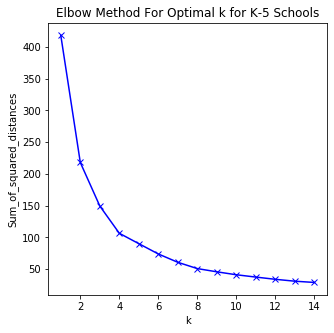

In [27]:
plt.figure(figsize=(5,5))

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k for K-5 Schools')
plt.show()

In [28]:
for i in range(2,10):
    cluster_eval(k5_X_std, i)


 ------2 Clusters------ 

K-Means Bin Count: [ 67 142]
K-Means Sillouhette Score: 0.44177701602127695
GMM Bin Count: [ 76 133]
GMM Silhouette Score for: 0.40385495277380623

 ------3 Clusters------ 

K-Means Bin Count: [59 63 87]
K-Means Sillouhette Score: 0.380401760425303
GMM Bin Count: [ 34 122  53]
GMM Silhouette Score for: 0.37397289380297793

 ------4 Clusters------ 

K-Means Bin Count: [34 77 46 52]
K-Means Sillouhette Score: 0.395537841018396
GMM Bin Count: [30 82 49 48]
GMM Silhouette Score for: 0.38160259021291065

 ------5 Clusters------ 

K-Means Bin Count: [35 32 44 33 65]
K-Means Sillouhette Score: 0.36121459258171806
GMM Bin Count: [27 35 47 41 59]
GMM Silhouette Score for: 0.3683552034492319

 ------6 Clusters------ 

K-Means Bin Count: [17 28 47 45 29 43]
K-Means Sillouhette Score: 0.3762524823835129
GMM Bin Count: [21 35 27 39 45 42]
GMM Silhouette Score for: 0.30809151707097815

 ------7 Clusters------ 

K-Means Bin Count: [20 37 43 41 28 23 17]
K-Means Sillouhette 

In [29]:
dbscan_eval(k5_X_std)


EPS: 0.25 Min_Samples: 5
(array([-1,  0,  1,  2,  3,  4,  5]), array([81, 22, 77,  9,  8,  7,  5]))
The silhouette score of the DBSCAN Clustering solution: -0.002638807015185676

EPS: 0.25 Min_Samples: 6
(array([-1,  0,  1,  2,  3,  4]), array([106,  17,  66,   7,   8,   5]))
The silhouette score of the DBSCAN Clustering solution: -0.12463914236884167

EPS: 0.25 Min_Samples: 7
(array([-1,  0,  1,  2,  3]), array([122,  16,  50,  14,   7]))
The silhouette score of the DBSCAN Clustering solution: -0.03377287422824013

EPS: 0.25 Min_Samples: 8
(array([-1,  0,  1,  2]), array([134,  12,  49,  14]))
The silhouette score of the DBSCAN Clustering solution: -0.07123047738362338

EPS: 0.25 Min_Samples: 9
(array([-1,  0,  1,  2]), array([137,  12,  42,  18]))
The silhouette score of the DBSCAN Clustering solution: -0.05873464484947406

EPS: 0.25 Min_Samples: 10
(array([-1,  0,  1,  2,  3,  4]), array([147,  13,  10,  14,  11,  14]))
The silhouette score of the DBSCAN Clustering solution: -0.130

The silhouette score of the DBSCAN Clustering solution: 0.28793844175180033

EPS: 0.5499999999999999 Min_Samples: 10
(array([-1,  0]), array([ 13, 196]))
The silhouette score of the DBSCAN Clustering solution: 0.28793844175180033

EPS: 0.5499999999999999 Min_Samples: 11
(array([-1,  0]), array([ 18, 191]))
The silhouette score of the DBSCAN Clustering solution: 0.26320255092628914

EPS: 0.5499999999999999 Min_Samples: 12
(array([-1,  0]), array([ 27, 182]))
The silhouette score of the DBSCAN Clustering solution: 0.2522642937128271

EPS: 0.5499999999999999 Min_Samples: 13
(array([-1,  0]), array([ 27, 182]))
The silhouette score of the DBSCAN Clustering solution: 0.2522642937128271

EPS: 0.5499999999999999 Min_Samples: 14
(array([-1,  0,  1]), array([ 32, 140,  37]))
The silhouette score of the DBSCAN Clustering solution: 0.3414417562759012

EPS: 0.5499999999999999 Min_Samples: 15
(array([-1,  0,  1]), array([ 33, 139,  37]))
The silhouette score of the DBSCAN Clustering solution: 0.341

The silhouette score of the DBSCAN Clustering solution: 0.3900599060018985

EPS: 0.8499999999999999 Min_Samples: 22
(array([-1,  0]), array([  5, 204]))
The silhouette score of the DBSCAN Clustering solution: 0.3900599060018985

EPS: 0.8499999999999999 Min_Samples: 23
(array([-1,  0]), array([  8, 201]))
The silhouette score of the DBSCAN Clustering solution: 0.3447040226342608

EPS: 0.9499999999999998 Min_Samples: 5
(array([-1,  0]), array([  1, 208]))
The silhouette score of the DBSCAN Clustering solution: 0.5110518529890251

EPS: 0.9499999999999998 Min_Samples: 6
(array([-1,  0]), array([  1, 208]))
The silhouette score of the DBSCAN Clustering solution: 0.5110518529890251

EPS: 0.9499999999999998 Min_Samples: 7
(array([-1,  0]), array([  1, 208]))
The silhouette score of the DBSCAN Clustering solution: 0.5110518529890251

EPS: 0.9499999999999998 Min_Samples: 8
(array([-1,  0]), array([  1, 208]))
The silhouette score of the DBSCAN Clustering solution: 0.5110518529890251

EPS: 0.949

In [30]:
# Silhouette schore points to having two clusters, so I'm going to create a 2 cluster label within my dataset.

k5_km = KMeans(n_clusters=2, random_state=13).fit_predict(k5_X_std)

# add cluster label to dataset

tmp = pd.DataFrame(k5_km)
k5_df['K-Means 2-Cluster'] = tmp.values

In [31]:
# Elbow method points to having four clusters, so I'm going to create a 4 cluster label within my dataset.

k5_km = KMeans(n_clusters=4, random_state=13).fit_predict(k5_X_std)

# add cluster label to dataset

tmp = pd.DataFrame(k5_km)
k5_df['K-Means 4-Cluster'] = tmp.values

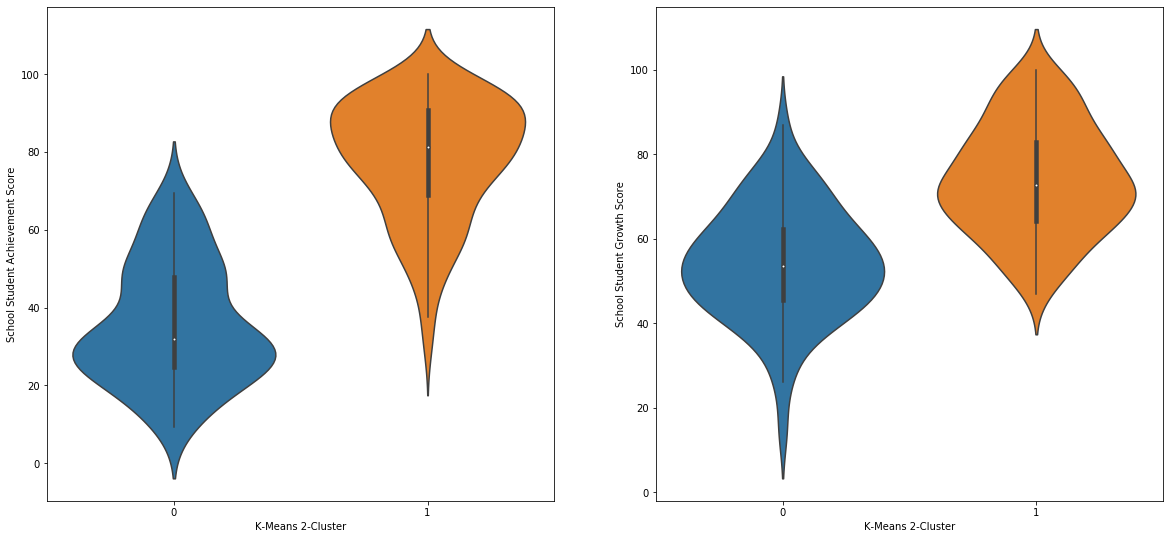

In [32]:
plt.figure(figsize=(20,20))

plt.subplot(221)
sns.violinplot(x='K-Means 2-Cluster', y='School Student Achievement Score', data=k5_df)

plt.subplot(222)
sns.violinplot(x='K-Means 2-Cluster', y='School Student Growth Score', data=k5_df)

plt.show()

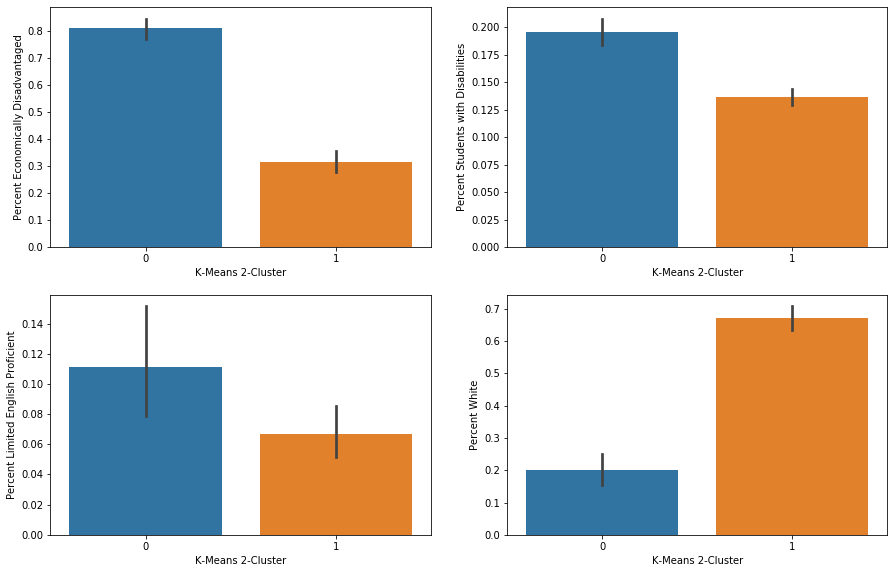

In [33]:
plt.figure(figsize=(15,15))

plt.subplot(321)
sns.barplot(x='K-Means 2-Cluster', y='Percent Economically Disadvantaged', data=k5_df)

plt.subplot(322)
sns.barplot(x='K-Means 2-Cluster', y='Percent Students with Disabilities', data=k5_df)

plt.subplot(323)
sns.barplot(x='K-Means 2-Cluster', y='Percent Limited English Proficient', data=k5_df)

plt.subplot(324)
sns.barplot(x='K-Means 2-Cluster', y='Percent White', data=k5_df)

plt.show()

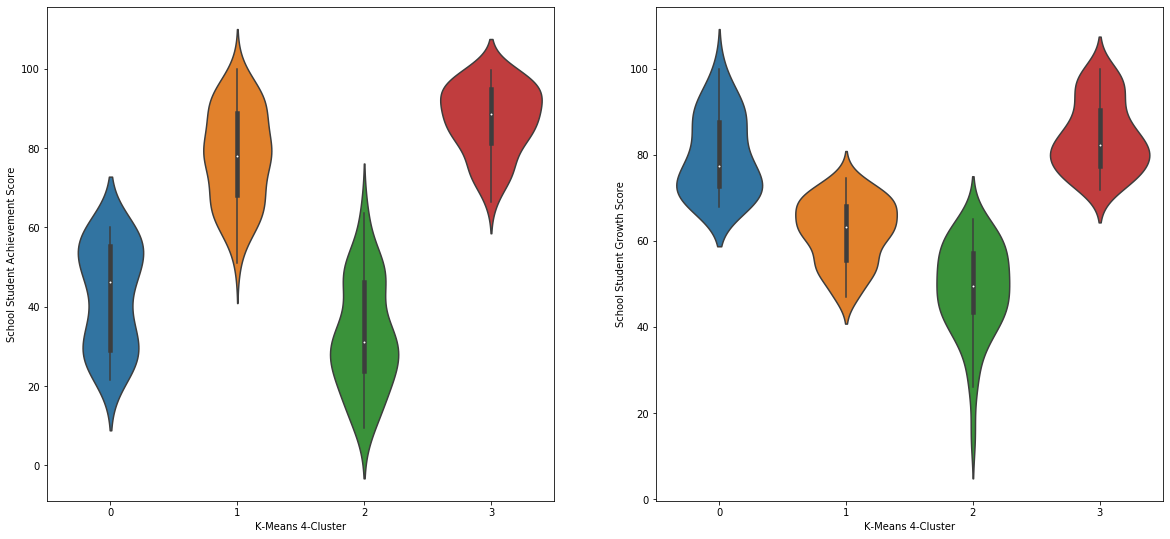

In [34]:
plt.figure(figsize=(20,20))

plt.subplot(221)
sns.violinplot(x='K-Means 4-Cluster', y='School Student Achievement Score', data=k5_df)

plt.subplot(222)
sns.violinplot(x='K-Means 4-Cluster', y='School Student Growth Score', data=k5_df)

plt.show()

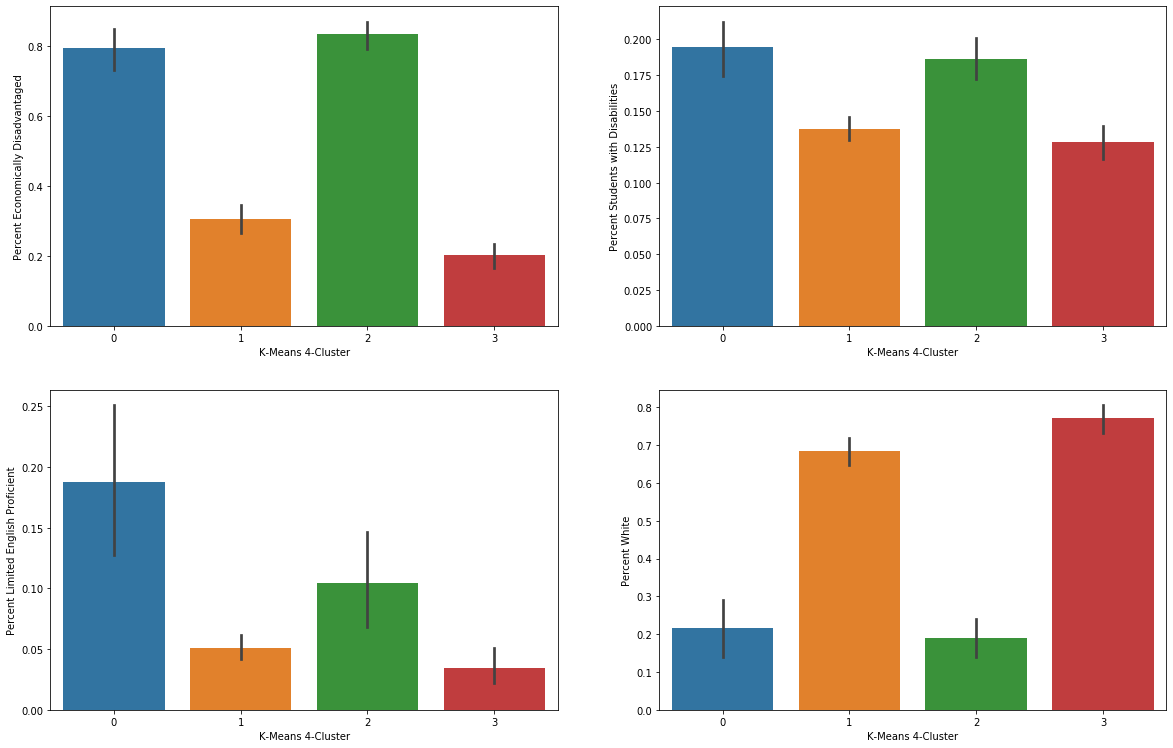

In [35]:
plt.figure(figsize=(20,20))

plt.subplot(321)
sns.barplot(x='K-Means 4-Cluster', y='Percent Economically Disadvantaged', data=k5_df)

plt.subplot(322)
sns.barplot(x='K-Means 4-Cluster', y='Percent Students with Disabilities', data=k5_df)

plt.subplot(323)
sns.barplot(x='K-Means 4-Cluster', y='Percent Limited English Proficient', data=k5_df)

plt.subplot(324)
sns.barplot(x='K-Means 4-Cluster', y='Percent White', data=k5_df)

plt.show()

In [36]:
red = k5_df[k5_df["K-Means 4-Cluster"] == 3]  
red[red["Percent Economically Disadvantaged"]> 0.5].head()

,School Year,District Name,School Name,Overall Accountability Score,Overall Accountability Rating,Lowest Grade in the School,Highest Grade in the School,School Type,School Enrollment,Percent American Indian or Alaskan Native,Percent Asian,Percent Black or African American,Percent Hispanic/Latino,Percent Native Hawaiian or Other Pacific Islander,Percent White,Percent Two or More Races,Percent Students with Disabilities,Percent Economically Disadvantaged,Percent Limited English Proficient,Percent School Choice Program,Percent Open Enrollment,School Student Achievement Score,School ELA Achievement Score,School Mathematics Achievement Score,School Student Growth Score,School ELA Growth Score,School Mathematics Growth Score,School Closing Gaps Score,School ELA Gap Score,School Mathematics Gap Score,School 4 Year Graduation Gap Score,School 6 Year Graduation Gap Score,School Graduation Gap Score,School On-Track and Postsecondary Readiness Score,School Graduation Rate Score,School Attendance Rate Score,School Third-Grade ELA Achievement Score,School Eighth-Grade Mathematics Achievement Score,School Student Achievement Max Score,School ELA Achievement Max Score,School Mathematics Achievement Max Score,School Student Growth Max Score,School ELA Growth Max Score,School Mathematics Growth Max Score,School Closing Gaps Max Score,School ELA Achievement Gap Max Score,School Mathematics Achievement Gap Max Score,School Graduation Gap Max Score,School On-Track and Postsecondary Readiness Max Score,School Graduation Rate Max Score,School Attendance Rate Max Score,School Third-Grade ELA Achievement Max Score,School Eighth-Grade Mathematics Achievement Max Score,State Student Achievement Score,State ELA Achievement Score,State Mathematics Achievement Score,State Student Growth Score,State ELA Growth Score,State Mathematics Growth Score,State Closing Gaps Score,State ELA Achievement Gaps Score,State Mathematics Achievement Gaps Score,State Graduation Gaps Score,State On-Track and Postsecondary Readiness Score,State Graduation Rate Score,State Attendance Rate Score,State Third-Grade ELA Achievement Score,State Eighth-Grade Mathematics Achievement Score,State Student Achievement Max Score,State ELA Achievement Max Score,State Mathematics Achievement Max Score,State Student Growth Max Score,State ELA Growth Max Score,State Mathematics Growth Max Score,State Closing Gaps Max Score,State ELA Achievement Gaps Max Score,State Mathematics Achievement Gaps Max Score,State 4 Year Graduation Gaps Max Score,State 6 Year Graduation Gaps Max Score,State Graduation Gaps Max Score,State On-Track and Postsecondary Readiness Max Score,State Graduation Rate Max Score,State Attendance Rate Max Score,State Third-Grade ELA Achievement Max Score,State Eighth-Grade Mathematics Achievement Max Score,Student Engagement Indicators Deduction,Absenteeism Rate Deduction,Dropout Rate Deduction,Test Partcipation ELA 2019 All Students,Test Partcipation ELA MULTI-YEAR All Students,Test Partcipation Mathematics 2019 All Students,Test Partcipation Mathematics MULTI-YEAR All Students,Subgroup with lowest test participation rate 2019,Test Partcipation ELA 2019 lowest rate subgroup,Test Partcipation ELA MULTI-YEAR lowest rate subgroup,Test Partcipation Mathematics 2019 lowest rate subgroup,Test Partcipation Mathematics MULTI-YEAR lowest rate subgroup,Score weighting Achievement Priority Area,Score weighting Growth Priority Area,Score weighting Closing Gaps Priority Area,Score weighting Ontrack Priority Area,School Percent Proficient ELA 2015,State Percent Proficient ELA 2015,School Percent Proficient Mathematics 2015,State Percent Proficient Mathematics 2015,School Percent Proficient ELA 2016,State Percent Proficient ELA 2016,School Percent Proficient Mathematics 2016,State Percent Proficient Mathematics 2016,School Percent Proficient ELA 2017,State Percent Proficient ELA 2017,School Percent Proficient Mathematics 2017,State Percent Proficient Mathematics 2017,School Percent Proficien

## K-5 Two-Cluster Findings

The K-5 school landscape appears to contain two main clusters. One cluster shows schools that have both high achievement and growth, and the other is populated with schools that are low in both categories. Looking within these clusters reveals that the cluster containing schools that are lower achieving and display lower growth have student populations that have:
1. 3x more students that are economically disadvantaged
2. 1.5x more students with disabilities
3. 2x more students learning English
4. 4x more students of color


## K-5 Four-Cluster Findings

Within the four clusters we see that there's more fine structure. There is a cluster of lower achieving schools that also demonstrate high growth as well as a group of higher achieving schools that display lower growth. Looking within these clusters we can see that:

1. the two lowest achieving clusters contain the majority of schools with high rates of economically disadvanted students, English learners and students of color. One of these clusters though displays high student growth.
2. of the two highest achieveing clusters, one cluster displays much lower student growth. 

## K-8 School Analysis

In [37]:
columns = ['School Student Achievement Score', 'School Student Growth Score', "Percent Economically Disadvantaged",
          "Percent White"]

k8_X = k8_df[columns]

In [38]:
# Standarizing the features
scaler = StandardScaler()
k8_X_std = scaler.fit_transform(k8_X)

In [39]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    k8_km = KMeans(n_clusters=k, random_state=13)
    k8_km = k8_km.fit(k8_X_std)
    Sum_of_squared_distances.append(k8_km.inertia_)

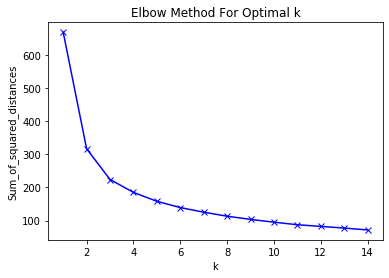

In [40]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [41]:
for i in range(2,10):
    cluster_eval(k8_X_std, i)


 ------2 Clusters------ 

K-Means Bin Count: [123  44]
K-Means Sillouhette Score: 0.49872279732283986
GMM Bin Count: [85 82]
GMM Silhouette Score for: 0.2908849646438413

 ------3 Clusters------ 

K-Means Bin Count: [69 41 57]
K-Means Sillouhette Score: 0.35798662249984314
GMM Bin Count: [20 67 80]
GMM Silhouette Score for: 0.15566773031231995

 ------4 Clusters------ 

K-Means Bin Count: [34 33 48 52]
K-Means Sillouhette Score: 0.3351897255488672
GMM Bin Count: [24 45 68 30]
GMM Silhouette Score for: 0.15380712283496972

 ------5 Clusters------ 

K-Means Bin Count: [39  9 34 33 52]
K-Means Sillouhette Score: 0.33471232074476814
GMM Bin Count: [27 16 68 30 26]
GMM Silhouette Score for: 0.1332366188573402

 ------6 Clusters------ 

K-Means Bin Count: [ 9 25 18 52 21 42]
K-Means Sillouhette Score: 0.31453316438484347
GMM Bin Count: [21 17 41 41 24 23]
GMM Silhouette Score for: 0.16950759837318125

 ------7 Clusters------ 

K-Means Bin Count: [16 35 16 39 36 16  9]
K-Means Sillouhette Sc

In [42]:
dbscan_eval(k8_X_std)


EPS: 0.25 Min_Samples: 5
(array([-1,  0]), array([156,  11]))
The silhouette score of the DBSCAN Clustering solution: -0.05043768576500961

EPS: 0.25 Min_Samples: 6
(array([-1,  0]), array([160,   7]))
The silhouette score of the DBSCAN Clustering solution: -0.1047722080316264

EPS: 0.25 Min_Samples: 7
(array([-1]), array([167]))
Everything is noise, no silhouette score.

EPS: 0.25 Min_Samples: 8
(array([-1]), array([167]))
Everything is noise, no silhouette score.

EPS: 0.25 Min_Samples: 9
(array([-1]), array([167]))
Everything is noise, no silhouette score.

EPS: 0.25 Min_Samples: 10
(array([-1]), array([167]))
Everything is noise, no silhouette score.

EPS: 0.25 Min_Samples: 11
(array([-1]), array([167]))
Everything is noise, no silhouette score.

EPS: 0.25 Min_Samples: 12
(array([-1]), array([167]))
Everything is noise, no silhouette score.

EPS: 0.25 Min_Samples: 13
(array([-1]), array([167]))
Everything is noise, no silhouette score.

EPS: 0.25 Min_Samples: 14
(array([-1]), arra

The silhouette score of the DBSCAN Clustering solution: 0.2612264643647781

EPS: 0.6499999999999999 Min_Samples: 7
(array([-1,  0]), array([72, 95]))
The silhouette score of the DBSCAN Clustering solution: 0.35862004979757506

EPS: 0.6499999999999999 Min_Samples: 8
(array([-1,  0]), array([74, 93]))
The silhouette score of the DBSCAN Clustering solution: 0.35523388538628903

EPS: 0.6499999999999999 Min_Samples: 9
(array([-1,  0]), array([76, 91]))
The silhouette score of the DBSCAN Clustering solution: 0.3421196678055999

EPS: 0.6499999999999999 Min_Samples: 10
(array([-1,  0]), array([76, 91]))
The silhouette score of the DBSCAN Clustering solution: 0.3421196678055999

EPS: 0.6499999999999999 Min_Samples: 11
(array([-1,  0]), array([83, 84]))
The silhouette score of the DBSCAN Clustering solution: 0.3203719431291485

EPS: 0.6499999999999999 Min_Samples: 12
(array([-1,  0]), array([83, 84]))
The silhouette score of the DBSCAN Clustering solution: 0.3203719431291485

EPS: 0.649999999999

The silhouette score of the DBSCAN Clustering solution: 0.44673431824113197

EPS: 0.9499999999999998 Min_Samples: 14
(array([-1,  0]), array([ 54, 113]))
The silhouette score of the DBSCAN Clustering solution: 0.44673431824113197

EPS: 0.9499999999999998 Min_Samples: 15
(array([-1,  0]), array([ 54, 113]))
The silhouette score of the DBSCAN Clustering solution: 0.44673431824113197

EPS: 0.9499999999999998 Min_Samples: 16
(array([-1,  0]), array([ 55, 112]))
The silhouette score of the DBSCAN Clustering solution: 0.4424997589154265

EPS: 0.9499999999999998 Min_Samples: 17
(array([-1,  0]), array([ 55, 112]))
The silhouette score of the DBSCAN Clustering solution: 0.4424997589154265

EPS: 0.9499999999999998 Min_Samples: 18
(array([-1,  0]), array([ 59, 108]))
The silhouette score of the DBSCAN Clustering solution: 0.42150582574614226

EPS: 0.9499999999999998 Min_Samples: 19
(array([-1,  0]), array([ 62, 105]))
The silhouette score of the DBSCAN Clustering solution: 0.4129280701522735

EP

In [43]:
k8_km = KMeans(n_clusters=2, random_state=13).fit_predict(k8_X_std)

# add cluster label to dataset

tmp = pd.DataFrame(k8_km)
k8_df['K-Means 2-Cluster'] = tmp.values

In [44]:
k8_km = KMeans(n_clusters=5, random_state=13).fit_predict(k8_X_std)

# add cluster label to dataset

tmp = pd.DataFrame(k8_km)
k8_df['K-Means 5-Cluster'] = tmp.values

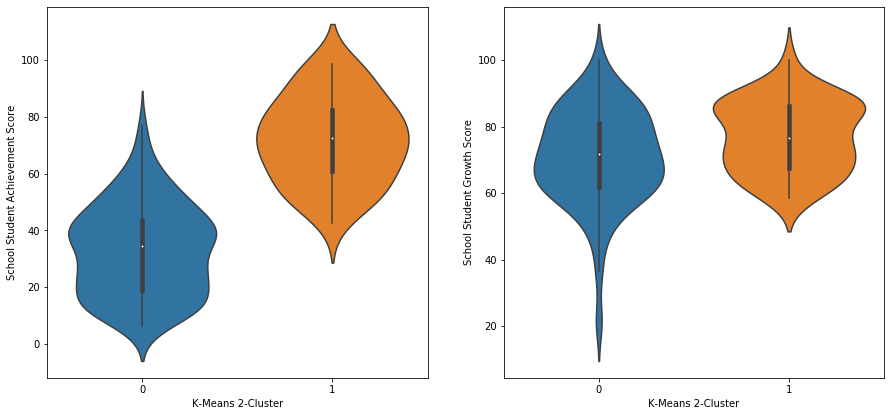

In [45]:
plt.figure(figsize=(15,15))

plt.subplot(221)
sns.violinplot(x='K-Means 2-Cluster', y='School Student Achievement Score', data=k8_df)

plt.subplot(222)
sns.violinplot(x='K-Means 2-Cluster', y='School Student Growth Score', data=k8_df)

plt.show()

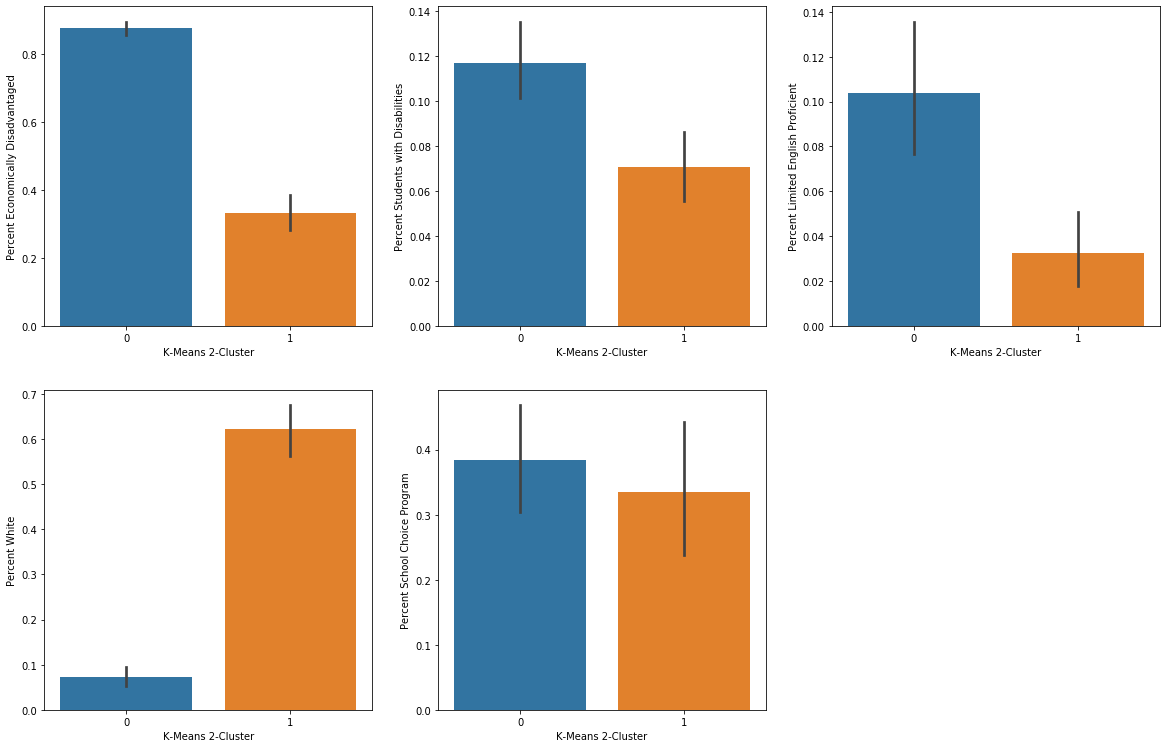

In [46]:
plt.figure(figsize=(20,20))

plt.subplot(331)
sns.barplot(x='K-Means 2-Cluster', y='Percent Economically Disadvantaged', data=k8_df)

plt.subplot(332)
sns.barplot(x='K-Means 2-Cluster', y='Percent Students with Disabilities', data=k8_df)

plt.subplot(333)
sns.barplot(x='K-Means 2-Cluster', y='Percent Limited English Proficient', data=k8_df)

plt.subplot(334)
sns.barplot(x='K-Means 2-Cluster', y='Percent White', data=k8_df)

plt.subplot(335)
sns.barplot(x='K-Means 2-Cluster', y='Percent School Choice Program', data=k8_df)

plt.show()

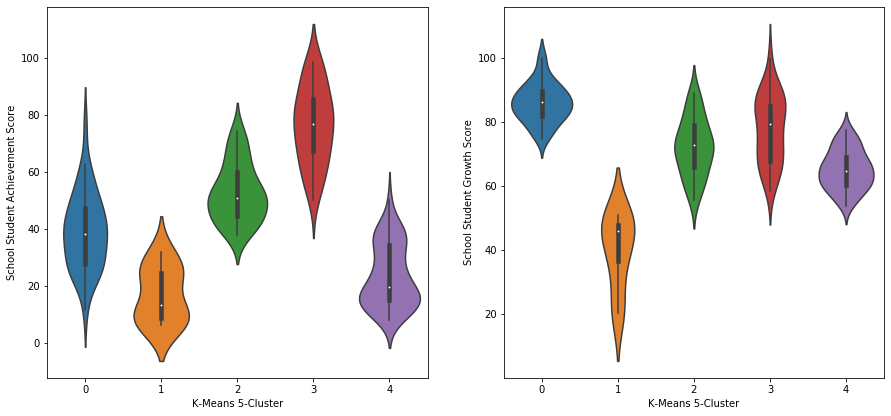

In [47]:
plt.figure(figsize=(15,15))

plt.subplot(221)
sns.violinplot(x='K-Means 5-Cluster', y='School Student Achievement Score', data=k8_df)

plt.subplot(222)
sns.violinplot(x='K-Means 5-Cluster', y='School Student Growth Score', data=k8_df)

plt.show()

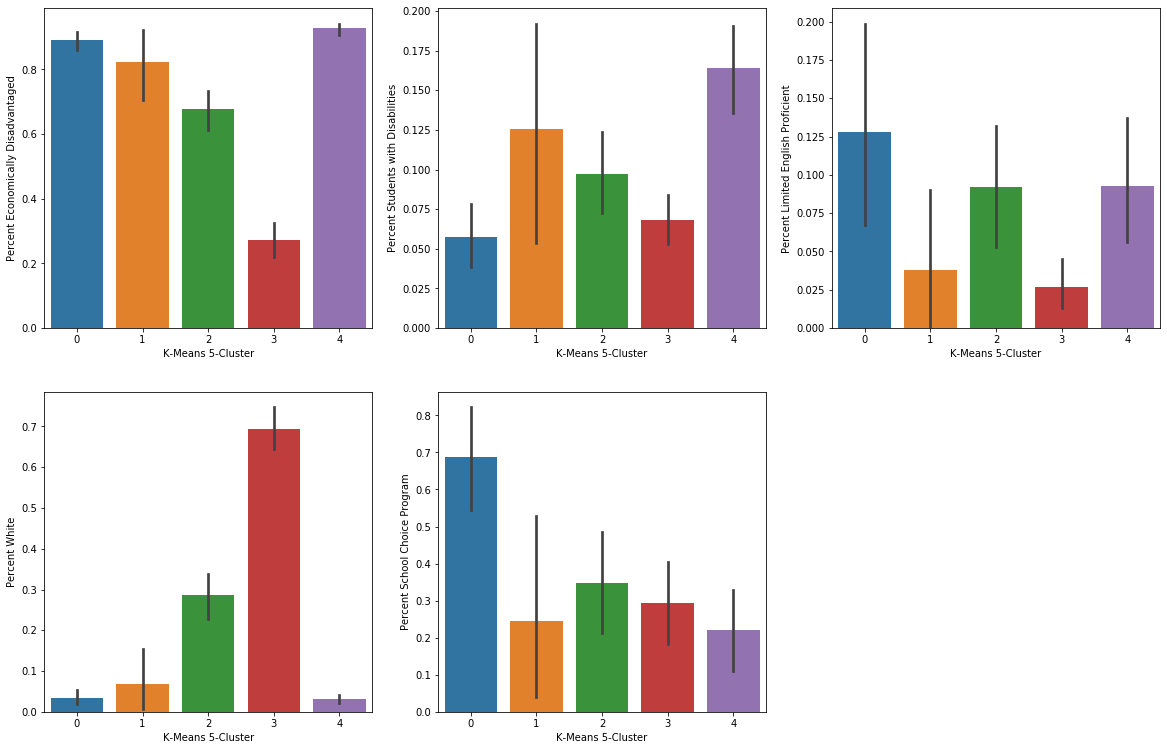

In [48]:
plt.figure(figsize=(20,20))

plt.subplot(331)
sns.barplot(x='K-Means 5-Cluster', y='Percent Economically Disadvantaged', data=k8_df)

plt.subplot(332)
sns.barplot(x='K-Means 5-Cluster', y='Percent Students with Disabilities', data=k8_df)

plt.subplot(333)
sns.barplot(x='K-Means 5-Cluster', y='Percent Limited English Proficient', data=k8_df)

plt.subplot(334)
sns.barplot(x='K-Means 5-Cluster', y='Percent White', data=k8_df)

plt.subplot(335)
sns.barplot(x='K-Means 5-Cluster', y='Percent School Choice Program', data=k8_df)

plt.show()

In [49]:
red = k8_df[k8_df["K-Means 5-Cluster"] == 3]  
red[red["Percent Economically Disadvantaged"]> 0.5].head()

,School Year,District Name,School Name,Overall Accountability Score,Overall Accountability Rating,Lowest Grade in the School,Highest Grade in the School,School Type,School Enrollment,Percent American Indian or Alaskan Native,Percent Asian,Percent Black or African American,Percent Hispanic/Latino,Percent Native Hawaiian or Other Pacific Islander,Percent White,Percent Two or More Races,Percent Students with Disabilities,Percent Economically Disadvantaged,Percent Limited English Proficient,Percent School Choice Program,Percent Open Enrollment,School Student Achievement Score,School ELA Achievement Score,School Mathematics Achievement Score,School Student Growth Score,School ELA Growth Score,School Mathematics Growth Score,School Closing Gaps Score,School ELA Gap Score,School Mathematics Gap Score,School 4 Year Graduation Gap Score,School 6 Year Graduation Gap Score,School Graduation Gap Score,School On-Track and Postsecondary Readiness Score,School Graduation Rate Score,School Attendance Rate Score,School Third-Grade ELA Achievement Score,School Eighth-Grade Mathematics Achievement Score,School Student Achievement Max Score,School ELA Achievement Max Score,School Mathematics Achievement Max Score,School Student Growth Max Score,School ELA Growth Max Score,School Mathematics Growth Max Score,School Closing Gaps Max Score,School ELA Achievement Gap Max Score,School Mathematics Achievement Gap Max Score,School Graduation Gap Max Score,School On-Track and Postsecondary Readiness Max Score,School Graduation Rate Max Score,School Attendance Rate Max Score,School Third-Grade ELA Achievement Max Score,School Eighth-Grade Mathematics Achievement Max Score,State Student Achievement Score,State ELA Achievement Score,State Mathematics Achievement Score,State Student Growth Score,State ELA Growth Score,State Mathematics Growth Score,State Closing Gaps Score,State ELA Achievement Gaps Score,State Mathematics Achievement Gaps Score,State Graduation Gaps Score,State On-Track and Postsecondary Readiness Score,State Graduation Rate Score,State Attendance Rate Score,State Third-Grade ELA Achievement Score,State Eighth-Grade Mathematics Achievement Score,State Student Achievement Max Score,State ELA Achievement Max Score,State Mathematics Achievement Max Score,State Student Growth Max Score,State ELA Growth Max Score,State Mathematics Growth Max Score,State Closing Gaps Max Score,State ELA Achievement Gaps Max Score,State Mathematics Achievement Gaps Max Score,State 4 Year Graduation Gaps Max Score,State 6 Year Graduation Gaps Max Score,State Graduation Gaps Max Score,State On-Track and Postsecondary Readiness Max Score,State Graduation Rate Max Score,State Attendance Rate Max Score,State Third-Grade ELA Achievement Max Score,State Eighth-Grade Mathematics Achievement Max Score,Student Engagement Indicators Deduction,Absenteeism Rate Deduction,Dropout Rate Deduction,Test Partcipation ELA 2019 All Students,Test Partcipation ELA MULTI-YEAR All Students,Test Partcipation Mathematics 2019 All Students,Test Partcipation Mathematics MULTI-YEAR All Students,Subgroup with lowest test participation rate 2019,Test Partcipation ELA 2019 lowest rate subgroup,Test Partcipation ELA MULTI-YEAR lowest rate subgroup,Test Partcipation Mathematics 2019 lowest rate subgroup,Test Partcipation Mathematics MULTI-YEAR lowest rate subgroup,Score weighting Achievement Priority Area,Score weighting Growth Priority Area,Score weighting Closing Gaps Priority Area,Score weighting Ontrack Priority Area,School Percent Proficient ELA 2015,State Percent Proficient ELA 2015,School Percent Proficient Mathematics 2015,State Percent Proficient Mathematics 2015,School Percent Proficient ELA 2016,State Percent Proficient ELA 2016,School Percent Proficient Mathematics 2016,State Percent Proficient Mathematics 2016,School Percent Proficient ELA 2017,State Percent Proficient ELA 2017,School Percent Proficient Mathematics 2017,State Percent Proficient Mathematics 2017,School Percent Proficien

## K-8 Two-Cluster Findings

The K-8 school landscape also contains two main clusters, similar to the K-5 landscape. But surprisingly:

1. The lower achievement group appears to show nearly the same average growth, but has a few very low outliers.
2. Similar demographic breakdown between the two groups as K-5
3. Private schools are about equally represented in the lower and higher achieving groups.


## K-8 Five-Cluster Findings

Based on the elbow method, the K-8 school landscape contains five clusters; a low-high group; a low-low, a middle-middle, a high-middle, and a low-middle group. 
1. The highest growth schools are also some of the lowest achieving. These schools have a high economically disadvantaged student of color population but have strikingly low numbers of students with disabilities, but have a high ELL population and are largely comprised of private schools. 
2. The low-low group is primarily an economically disadvantaged population, with low ELL (meaning AA) and mostly public schools. 

## K-8 Five-Cluster Findings Cont.

3. The middle-middle group is a mix of private and public schools, serving a moderate amount of students from different backgrounds.
4. The high-middle group are schools with mainly white, non-economically disadvantaged students, again a mix of private and public schools.
5. Lastly the low-middle group schools have students that are highly economically disadvantaged, but include many fewer private schools than the first group.

## High School Analysis

In [50]:
columns = ['School Student Achievement Score', 'School Student Growth Score', "Percent Economically Disadvantaged",
          "Percent White"]

hs_X = hs_df[columns]

In [51]:
# Standarizing the features
scaler = StandardScaler()
hs_X_std = scaler.fit_transform(hs_X)

In [52]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    hs_km = KMeans(n_clusters=k, random_state=13)
    hs_km = hs_km.fit(hs_X_std)
    Sum_of_squared_distances.append(hs_km.inertia_)

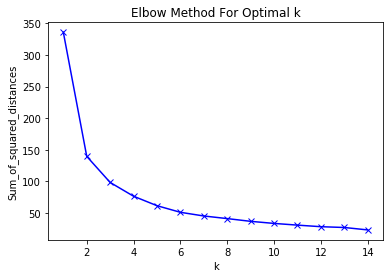

In [53]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [54]:
for i in range(2,10):
    cluster_eval(hs_X_std, i)


 ------2 Clusters------ 

K-Means Bin Count: [48 36]
K-Means Sillouhette Score: 0.4752836576124331
GMM Bin Count: [52 32]
GMM Silhouette Score for: 0.4310513998281291

 ------3 Clusters------ 

K-Means Bin Count: [27 35 22]
K-Means Sillouhette Score: 0.39595847868999196
GMM Bin Count: [23 28 33]
GMM Silhouette Score for: 0.3561373156760681

 ------4 Clusters------ 

K-Means Bin Count: [19 14 23 28]
K-Means Sillouhette Score: 0.3855473224276876
GMM Bin Count: [ 9 13 29 33]
GMM Silhouette Score for: 0.22366158731867372

 ------5 Clusters------ 

K-Means Bin Count: [21 18 17 17 11]
K-Means Sillouhette Score: 0.3722815551703197
GMM Bin Count: [ 7 14 18 18 27]
GMM Silhouette Score for: 0.27160105257246686

 ------6 Clusters------ 

K-Means Bin Count: [16 13 13 14 18 10]
K-Means Sillouhette Score: 0.3798270753044052
GMM Bin Count: [14 13 18 12 17 10]
GMM Silhouette Score for: 0.30914178958271865

 ------7 Clusters------ 

K-Means Bin Count: [ 9 18  8  9 14 13 13]
K-Means Sillouhette Score: 

In [55]:
dbscan_eval(hs_X_std)


EPS: 0.25 Min_Samples: 5
(array([-1]), array([84]))
Everything is noise, no silhouette score.

EPS: 0.25 Min_Samples: 6
(array([-1]), array([84]))
Everything is noise, no silhouette score.

EPS: 0.25 Min_Samples: 7
(array([-1]), array([84]))
Everything is noise, no silhouette score.

EPS: 0.25 Min_Samples: 8
(array([-1]), array([84]))
Everything is noise, no silhouette score.

EPS: 0.25 Min_Samples: 9
(array([-1]), array([84]))
Everything is noise, no silhouette score.

EPS: 0.25 Min_Samples: 10
(array([-1]), array([84]))
Everything is noise, no silhouette score.

EPS: 0.25 Min_Samples: 11
(array([-1]), array([84]))
Everything is noise, no silhouette score.

EPS: 0.25 Min_Samples: 12
(array([-1]), array([84]))
Everything is noise, no silhouette score.

EPS: 0.25 Min_Samples: 13
(array([-1]), array([84]))
Everything is noise, no silhouette score.

EPS: 0.25 Min_Samples: 14
(array([-1]), array([84]))
Everything is noise, no silhouette score.

EPS: 0.25 Min_Samples: 15
(array([-1]), arra

(array([-1,  0,  1]), array([46, 25, 13]))
The silhouette score of the DBSCAN Clustering solution: 0.24850629671588495

EPS: 0.6499999999999999 Min_Samples: 9
(array([-1,  0,  1]), array([52, 22, 10]))
The silhouette score of the DBSCAN Clustering solution: 0.18093877255831473

EPS: 0.6499999999999999 Min_Samples: 10
(array([-1,  0]), array([62, 22]))
The silhouette score of the DBSCAN Clustering solution: 0.35887501464623367

EPS: 0.6499999999999999 Min_Samples: 11
(array([-1,  0]), array([66, 18]))
The silhouette score of the DBSCAN Clustering solution: 0.3075899113343371

EPS: 0.6499999999999999 Min_Samples: 12
(array([-1,  0]), array([66, 18]))
The silhouette score of the DBSCAN Clustering solution: 0.3075899113343371

EPS: 0.6499999999999999 Min_Samples: 13
(array([-1,  0]), array([68, 16]))
The silhouette score of the DBSCAN Clustering solution: 0.2718998287111384

EPS: 0.6499999999999999 Min_Samples: 14
(array([-1,  0]), array([68, 16]))
The silhouette score of the DBSCAN Cluste

The silhouette score of the DBSCAN Clustering solution: 0.2667868329619415

EPS: 0.9499999999999998 Min_Samples: 16
(array([-1,  0]), array([59, 25]))
The silhouette score of the DBSCAN Clustering solution: 0.386259687763375

EPS: 0.9499999999999998 Min_Samples: 17
(array([-1,  0]), array([59, 25]))
The silhouette score of the DBSCAN Clustering solution: 0.386259687763375

EPS: 0.9499999999999998 Min_Samples: 18
(array([-1,  0]), array([59, 25]))
The silhouette score of the DBSCAN Clustering solution: 0.386259687763375

EPS: 0.9499999999999998 Min_Samples: 19
(array([-1,  0]), array([59, 25]))
The silhouette score of the DBSCAN Clustering solution: 0.386259687763375

EPS: 0.9499999999999998 Min_Samples: 20
(array([-1,  0]), array([64, 20]))
The silhouette score of the DBSCAN Clustering solution: 0.28525348863635935

EPS: 0.9499999999999998 Min_Samples: 21
(array([-1]), array([84]))
Everything is noise, no silhouette score.

EPS: 0.9499999999999998 Min_Samples: 22
(array([-1]), array([8

In [56]:
# Clustering

hs_km = KMeans(n_clusters=2, random_state=13).fit_predict(hs_X_std)

# add cluster labels to dataset

tmp = pd.DataFrame(hs_km)
hs_df['K-Means 2-Cluster'] = tmp.values

hs_km = KMeans(n_clusters=5, random_state=13).fit_predict(hs_X_std)
tmp = pd.DataFrame(hs_km)
hs_df['K-Means 5-Cluster'] = tmp.values



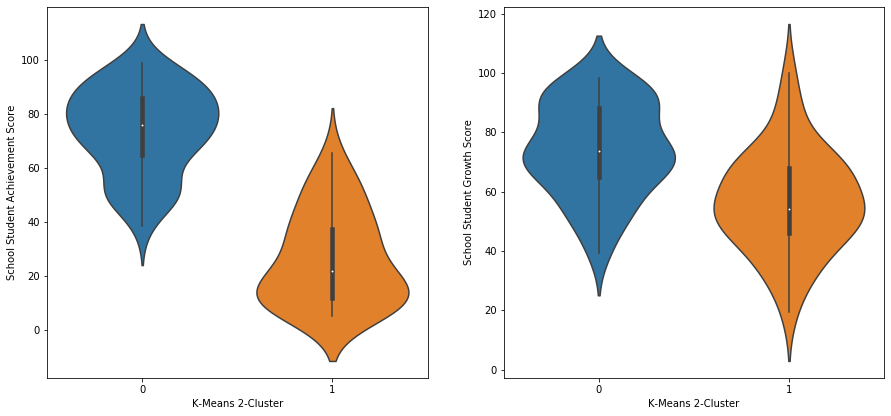

In [57]:
plt.figure(figsize=(15,15))

plt.subplot(221)
sns.violinplot(x='K-Means 2-Cluster', y='School Student Achievement Score', data=hs_df)

plt.subplot(222)
sns.violinplot(x='K-Means 2-Cluster', y='School Student Growth Score', data=hs_df)

plt.show()

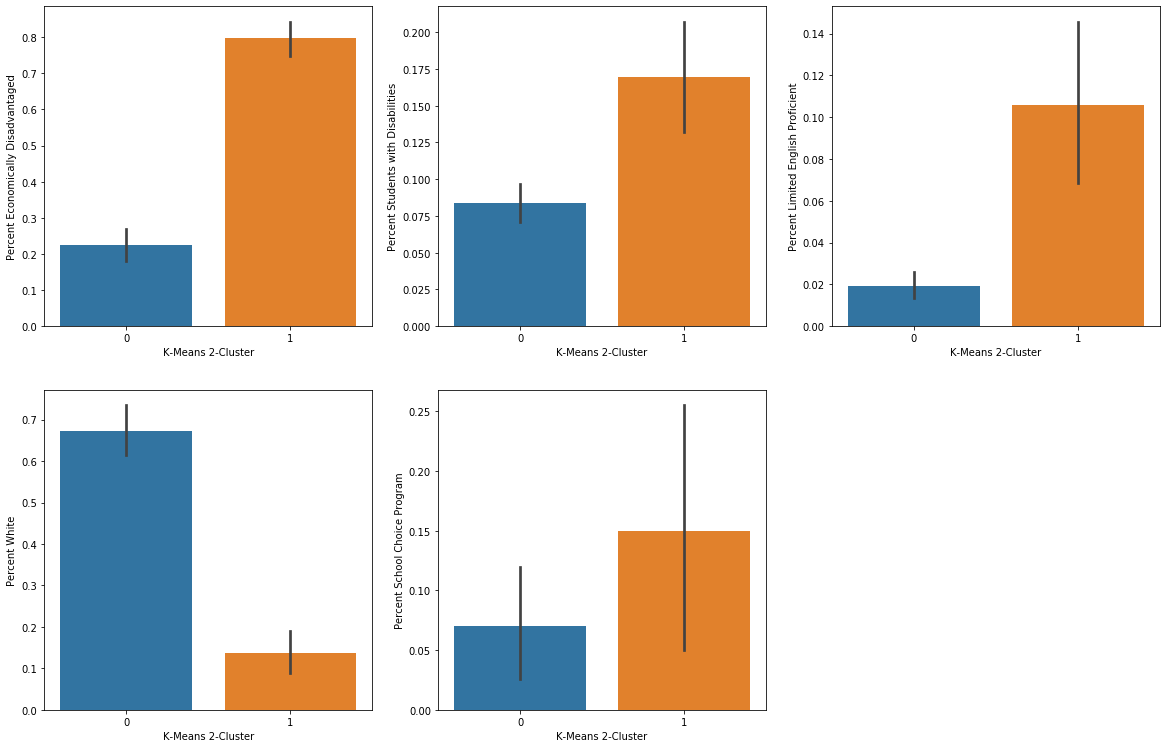

In [58]:
plt.figure(figsize=(20,20))

plt.subplot(331)
sns.barplot(x='K-Means 2-Cluster', y='Percent Economically Disadvantaged', data=hs_df)

plt.subplot(332)
sns.barplot(x='K-Means 2-Cluster', y='Percent Students with Disabilities', data=hs_df)

plt.subplot(333)
sns.barplot(x='K-Means 2-Cluster', y='Percent Limited English Proficient', data=hs_df)

plt.subplot(334)
sns.barplot(x='K-Means 2-Cluster', y='Percent White', data=hs_df)

plt.subplot(335)
sns.barplot(x='K-Means 2-Cluster', y='Percent School Choice Program', data=hs_df)

plt.show()

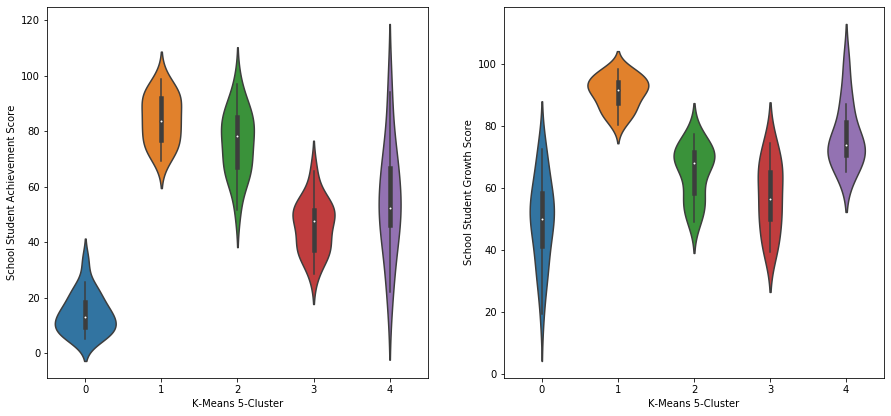

In [59]:
plt.figure(figsize=(15,15))

plt.subplot(221)
sns.violinplot(x='K-Means 5-Cluster', y='School Student Achievement Score', data=hs_df)

plt.subplot(222)
sns.violinplot(x='K-Means 5-Cluster', y='School Student Growth Score', data=hs_df)

plt.show()

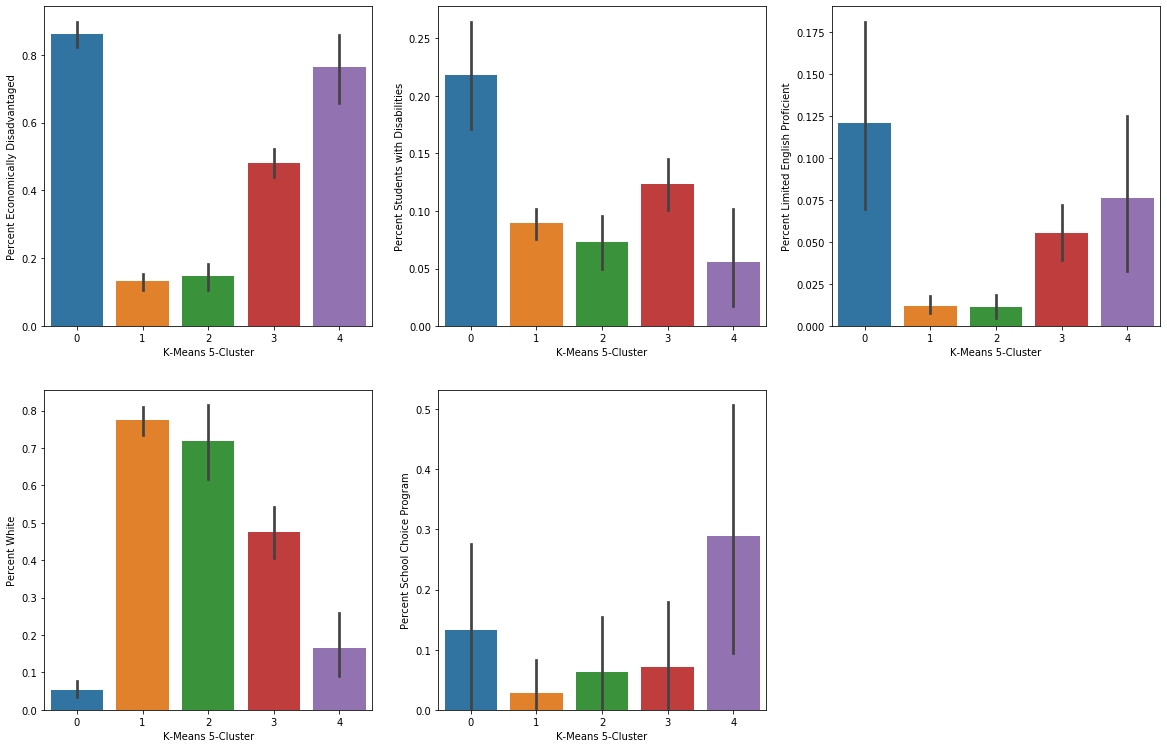

In [60]:
plt.figure(figsize=(20,20))

plt.subplot(331)
sns.barplot(x='K-Means 5-Cluster', y='Percent Economically Disadvantaged', data=hs_df)

plt.subplot(332)
sns.barplot(x='K-Means 5-Cluster', y='Percent Students with Disabilities', data=hs_df)

plt.subplot(333)
sns.barplot(x='K-Means 5-Cluster', y='Percent Limited English Proficient', data=hs_df)

plt.subplot(334)
sns.barplot(x='K-Means 5-Cluster', y='Percent White', data=hs_df)

plt.subplot(335)
sns.barplot(x='K-Means 5-Cluster', y='Percent School Choice Program', data=hs_df)

plt.show()

In [61]:
purp = hs_df[hs_df["K-Means 5-Cluster"] == 4]  
purp[purp["School Student Growth Score"]> 85].head()

,School Year,District Name,School Name,Overall Accountability Score,Overall Accountability Rating,Lowest Grade in the School,Highest Grade in the School,School Type,School Enrollment,Percent American Indian or Alaskan Native,Percent Asian,Percent Black or African American,Percent Hispanic/Latino,Percent Native Hawaiian or Other Pacific Islander,Percent White,Percent Two or More Races,Percent Students with Disabilities,Percent Economically Disadvantaged,Percent Limited English Proficient,Percent School Choice Program,Percent Open Enrollment,School Student Achievement Score,School ELA Achievement Score,School Mathematics Achievement Score,School Student Growth Score,School ELA Growth Score,School Mathematics Growth Score,School Closing Gaps Score,School ELA Gap Score,School Mathematics Gap Score,School 4 Year Graduation Gap Score,School 6 Year Graduation Gap Score,School Graduation Gap Score,School On-Track and Postsecondary Readiness Score,School Graduation Rate Score,School Attendance Rate Score,School Third-Grade ELA Achievement Score,School Eighth-Grade Mathematics Achievement Score,School Student Achievement Max Score,School ELA Achievement Max Score,School Mathematics Achievement Max Score,School Student Growth Max Score,School ELA Growth Max Score,School Mathematics Growth Max Score,School Closing Gaps Max Score,School ELA Achievement Gap Max Score,School Mathematics Achievement Gap Max Score,School Graduation Gap Max Score,School On-Track and Postsecondary Readiness Max Score,School Graduation Rate Max Score,School Attendance Rate Max Score,School Third-Grade ELA Achievement Max Score,School Eighth-Grade Mathematics Achievement Max Score,State Student Achievement Score,State ELA Achievement Score,State Mathematics Achievement Score,State Student Growth Score,State ELA Growth Score,State Mathematics Growth Score,State Closing Gaps Score,State ELA Achievement Gaps Score,State Mathematics Achievement Gaps Score,State Graduation Gaps Score,State On-Track and Postsecondary Readiness Score,State Graduation Rate Score,State Attendance Rate Score,State Third-Grade ELA Achievement Score,State Eighth-Grade Mathematics Achievement Score,State Student Achievement Max Score,State ELA Achievement Max Score,State Mathematics Achievement Max Score,State Student Growth Max Score,State ELA Growth Max Score,State Mathematics Growth Max Score,State Closing Gaps Max Score,State ELA Achievement Gaps Max Score,State Mathematics Achievement Gaps Max Score,State 4 Year Graduation Gaps Max Score,State 6 Year Graduation Gaps Max Score,State Graduation Gaps Max Score,State On-Track and Postsecondary Readiness Max Score,State Graduation Rate Max Score,State Attendance Rate Max Score,State Third-Grade ELA Achievement Max Score,State Eighth-Grade Mathematics Achievement Max Score,Student Engagement Indicators Deduction,Absenteeism Rate Deduction,Dropout Rate Deduction,Test Partcipation ELA 2019 All Students,Test Partcipation ELA MULTI-YEAR All Students,Test Partcipation Mathematics 2019 All Students,Test Partcipation Mathematics MULTI-YEAR All Students,Subgroup with lowest test participation rate 2019,Test Partcipation ELA 2019 lowest rate subgroup,Test Partcipation ELA MULTI-YEAR lowest rate subgroup,Test Partcipation Mathematics 2019 lowest rate subgroup,Test Partcipation Mathematics MULTI-YEAR lowest rate subgroup,Score weighting Achievement Priority Area,Score weighting Growth Priority Area,Score weighting Closing Gaps Priority Area,Score weighting Ontrack Priority Area,School Percent Proficient ELA 2015,State Percent Proficient ELA 2015,School Percent Proficient Mathematics 2015,State Percent Proficient Mathematics 2015,School Percent Proficient ELA 2016,State Percent Proficient ELA 2016,School Percent Proficient Mathematics 2016,State Percent Proficient Mathematics 2016,School Percent Proficient ELA 2017,State Percent Proficient ELA 2017,School Percent Proficient Mathematics 2017,State Percent Proficient Mathematics 2017,School Percent Proficien

## High School Two-Cluster Findings

The HS school landscape also contains two main clusters, similar to the K-5 and K-8 landscapes. Some differences between HS and the lower grade schools are that:

1. It appears there 3x more private schools students in the lower-achieving school group than in the higher-achieving school group at the high school level.
2. Similar demographic breakdown between the two groups as K-5 and K-8.

## High School Five-Cluster Findings

There is some similarity to the K-8 school clusters, but there are some important outliers within the groups. 
1. In the lower achieving group there are some very high growth schools. These schools have very high economically disadvantaged student populations, with high numbers of students with disabilities and ELL students. 
2. There are some very high achieving and very high growth schools that have a low percentage of private school students of color, low ELL counts, low numbers of students with disabilities, and low percentage of economically disadvantaged students. 

## High School Five-Cluster Findings Cont.

3. Lastly there is a group of schools that have high growth but a wide range of achievement from the very high to the very low. These schools appear to contain much higher counts of private school students, serve a lot of low income students of color and low numbers of students with disabilities

## Conclusion

Horace Mann, a pioneer of American public schools in the 19th century, famously called education the “great equalizer of the conditions of men.” As this analysis has shown though, that simply isn't true for many students in the Milwaukee area.

As this analysis has shown, schools at all levels are highly segregated along lines of race, economic prosperity, disability status and English proficiency status. This segregation is also accompanied by striking differences in student achievement and growth. At the same time though there are clusters of schools at all levels that are defying these trends and exhibiting high growth. 

## Conclusion Cont.

It is my hope that continued analysis and dialogue about the vast differences in schools will lead to a mobilization by education and community leaders, policy makers, and tax payers to ensure that all students receive a free, quality education. 

## Further Analysis

Additional analysis I would like to do is:
1. look within these clusters at the outliers. 
2. utilize more clusters to further break down the different types of schools
3. combine this data set with information about the different cities: demographics and economic prosperity